# Machine Learning with XGBoost
This notebook is a hypothetical Machine Learing Operations guide, starting with naive modeling and progressing through more and more complex usage of XGBoost and finally performing Hyperparameter Optimization using feature engineered data.

### [YouTube Tutorial](https://www.youtube.com/watch?v=lhraJRaDkOA)
##### This YouTube video is a walk through of this notebook

<a href="https://www.youtube.com/watch?v=lhraJRaDkOA">
  <img src="https://img.youtube.com/vi/lhraJRaDkOA/2.jpg" width="250">
</a>

# What is XGBoost?

* Stands for **Extreme Gradient Boosting**
* The leading machine learning library for regression, classification, and ranking problems
* [GPU Accelerated](https://xgboost.readthedocs.io/en/stable/gpu/index.html) with a single parameter
* Scalable, distributed gradient-boosted decision tree (GBDT) machine learning library
* Graphical feature importance enhances explainability
* Provides parallel tree boosting
* More information [here](https://xgboost.readthedocs.io/en/stable/index.html)







# Notebook Outline
#### Environment
#### Data
#### Mean Model
#### Medan Model
#### <i>Naive</i> XGBoost 
#### Feature Engineering
#### XGBoost Light Tuning
#### Performance
#### Automated Tuning

<br/>

In [1]:
# this code helps avoid local warnings when running in a Colab notebook.
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# Environment

### GPU Verification
The `nvidia-smi` command line provide details about your GPU and drivers.

In [2]:
!nvidia-smi

Thu Jun 26 13:21:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             43W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

<br/>

### XGBoost Version
It is beneficial to get the latest version of XGBoost to get the latest algorithm advancements.

In [3]:
!pip install -q --upgrade xgboost
import xgboost as xgb
xgb.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 9.9 MB/s eta 0:00:00


'3.0.2'

#### XGBoost version - 2.1.3 needs downgraded Scikit-learn
`!pip uninstall -y scikit-learn`
`!pip install -q scikit-learn==1.5.2`

### NVIDA CUDA-X Verification

##### `%load_ext cudf.pandas` will load a GPU Acclerated proxy type for pandas.
##### More details can be found here: 
https://developer.nvidia.com/topics/ai/data-science/cuda-x-data-science-libraries
##### This short blog also provides code samples for alternate method of accelerated pandas with NVIDIA GPUs
https://developer.nvidia.com/blog/rapids-cudf-accelerates-pandas-nearly-150x-with-zero-code-changes/

In [5]:
# load CUDA-X GPU-accelerated pandas --> cuDF
# https://rapids.ai
%load_ext cudf.pandas

##### The 'pd' display should be `<module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>` to indicate we are using GPU accelerated pandas via [NVIDIA cuDF](https://developer.nvidia.com/topics/ai/data-science/cuda-x-data-science-libraries)

In [6]:
import xgboost as xgb
import pandas as pd
import numpy as np


pd # this should display: <module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>

<module 'pandas' (ModuleAccelerator(fast=cudf, slow=pandas))>

<br/>

<br/>

# Data - City of Chicago Taxi Trips Data
##### From the web page:  
<i>Chicago taxi trips from 2013 to 2023 reported to the City of Chicago in its role as a regulatory agency.</i>  
##### Data details can be found here:
https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/about_data
##### Download the data from here:
https://data.cityofchicago.org/Transportation/Taxi-Trips-2013-2023-/wrvz-psew/data_preview

I have the data in my Google Drive and dowload it with the following commands from a Google Colab notebook:

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!cp /content/drive/MyDrive/Taxi_Trips__2013-2023__20241218.csv .

In [10]:
!wc -l Taxi_Trips__2013-2023__20241218.csv

1972429 Taxi_Trips__2013-2023__20241218.csv


### GPU or CPU
##### I use the variable to set the accelerator type within XGBoost. `cuda` will accelerate XGBoost on the [NVIDIA GPU](https://xgboost.readthedocs.io/en/stable/gpu/index.html).

In [11]:
# USC CPU
# xgb_device = "cpu"

# USE GPU - comment out following lines to use CPU
xgb_device = "cuda"
xgb_device

'cuda'

In [12]:
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

<br/>

### CSV
##### The following code loads the data into a pandas DataFrame. 'read_csv' is a GPU accelerated function within NVIDIA cuDF.

In [13]:
%%time

df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data

CPU times: user 312 ms, sys: 255 ms, total: 566 ms
Wall time: 453 ms


In [14]:
%%time

df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name

df = df[df["trip_ttl"]>0]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df.drop(columns=["trip_ttl"])
y = df["trip_ttl"]

CPU times: user 439 ms, sys: 81.4 ms, total: 520 ms
Wall time: 1.29 s


In [15]:
%%time

start = time()
# RAPIDS OFF  - 22.04 seconds
# RAPIDS A100 -  0.26 seconds

df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data

df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name

df = df[df["trip_ttl"]>0]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

X = df.drop(columns=["trip_ttl"])
y = df["trip_ttl"]

time() - start

CPU times: user 332 ms, sys: 178 ms, total: 510 ms
Wall time: 260 ms


0.2600255012512207

In [16]:
len(df)

1971068

<br/>

<br/>

<br/>

<br/>

# Mean Model
##### A typical Machine Learning Operation is to start with a naive models to create a peformance floor or baseline performance to start at.
##### This code creates a Mean model and saves the results to compare to future models

In [17]:
y.mean().round(2).item()

17.58

In [19]:
%%time

# RAPIDS OFF  - 1.22
# RAPIDS A100 - 0.690

kf = KFold(n_splits=5, shuffle=True, random_state=42)

mean_fold_results = {"avg":[], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

for fold, (train_index, test_index) in enumerate(kf.split(y)):

  # get folds
  y_train, y_true = y[train_index], y[test_index]

  # "mean model"
  y_pred = y_train.mean()
  mean_fold_results["avg"].append(y_pred)

  # calculate metrics
  mse = ((y_true - y_pred) ** 2).mean()
  mean_fold_results["mse"].append(mse)
  mean_fold_results["rmse"].append(mse  ** 0.5)
  mae = (y_true - y_pred).abs().mean()
  mean_fold_results["mae"].append(mae)
  ss_residual = ((y_true - y_pred) ** 2).sum()
  ss_total = ((y_true - y_true.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  mean_fold_results["r2"].append(1 - (ss_residual / ss_total))
  mean_fold_results["max_err"].append((y_true - y_pred).abs().max())

mean_fold_results_df = pd.DataFrame(mean_fold_results)
mean_fold_results_df

CPU times: user 644 ms, sys: 72.1 ms, total: 716 ms
Wall time: 690 ms


,avg,mse,rmse,mae,r2,max_err
0,17.532107,9141.875107,95.613153,13.542402,-6.023739e-06,9782.767893
1,17.617675,7639.707685,87.405421,13.250784,-4.884284e-06,9882.682325
2,17.616017,6383.971635,79.899760,13.259757,-5.354304e-06,9034.833983
3,17.549724,8855.465930,94.103485,13.516449,-2.426406e-06,9957.770276
4,17.579680,8401.307659,91.658647,13.400753,-1.217141e-09,9682.670320


### The Mean model results show decent results from which to start

In [20]:
mean_results_df = pd.DataFrame({'model': 'mean',**mean_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': mean_fold_results_df['max_err'].max()}, index=[0])
mean_results_df.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,mean,17.58,8084.47,89.74,13.39,-0.0,9957.77


<br/>

<br/>

# Median Model
##### A typical Machine Learning Operation is to start with a naive models to create a peformance floor or baseline performance to start at.
##### This code creates a Median model and saves the results to compare to future models including previous Mean model.

In [21]:
y.median()

np.float64(9.75)

In [22]:
%%time
# RAPIDS OFF  - 0.959
# RAPIDS A100 - 0.771

median_fold_results = {"avg":[], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}
for fold, (train_index, test_index) in enumerate(kf.split(y)):

  # get folds
  y_train, y_true = y[train_index], y[test_index]

  # "median model"
  y_pred = y_train.median()
  median_fold_results["avg"].append(y_pred)

  # calculate metrics
  mse = ((y_true - y_pred) ** 2).mean()
  median_fold_results["mse"].append(mse)
  median_fold_results["rmse"].append(mse ** 0.5)
  mae = (y_true - y_pred).abs().mean()
  median_fold_results["mae"].append(mae)
  ss_residual = ((y_true - y_pred) ** 2).sum()
  ss_total = ((y_true - y_true.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  median_fold_results["r2"].append(1 - (ss_residual / ss_total))
  median_fold_results["max_err"].append((y_true - y_pred).abs().max())

median_fold_results_df = pd.DataFrame(median_fold_results)

CPU times: user 709 ms, sys: 88.8 ms, total: 797 ms
Wall time: 771 ms


### The Median model does not show an significant improvement

In [23]:
median_results_df = pd.DataFrame({'model': 'median', **median_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': median_fold_results_df['max_err'].max()}, index=[0])
pd.concat([mean_results_df, median_results_df]).round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,mean,17.58,8084.47,89.74,13.39,-0.00,9957.77
0,median,9.75,8145.75,90.08,10.52,-0.01,9965.57


<br/>

<br/>

# Naive XGBoost
##### This code creates and tests an XGBoost model with the default parameters and accelerated with a GPU

In [24]:
%%time

# RAPIDS OFF  - 48.2, 40.5
# RAPIDS A100 - 0.456 (x114 speedup)

df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data

df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name

df = df[df["trip_ttl"]>0]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])
df = df.drop(columns=["Trip ID", "Taxi ID", "Pickup Centroid Location", "Dropoff Centroid  Location", "Payment Type", "Company"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip Start Timestamp"] = (df["Trip Start Timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df["Trip End Timestamp"] = (df["Trip End Timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

y = df["trip_ttl"]
X = df.drop(columns=["trip_ttl"])

CPU times: user 455 ms, sys: 189 ms, total: 644 ms
Wall time: 456 ms


In [25]:
%%time

# RAPIDS OFF  - 117.26
# RAPIDS A100 - 5.71 (x20 speedup)

import xgboost as xgb

xgb_naive_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

for fold, (train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # train
  xgb_model = xgb.XGBRegressor(device=xgb_device)

  xgb_model.fit(X_train, y_train)
  y_pred = xgb_model.predict(X_test)
  xgb_naive_fold_results["avg"].append(y_pred.mean())

  # metrics
  mse = ((y_test - y_pred) ** 2).mean()
  xgb_naive_fold_results["mse"].append(mse)
  xgb_naive_fold_results["rmse"].append(mse ** 0.5)
  mae = (y_test - y_pred).abs().mean()
  xgb_naive_fold_results["mae"].append(mae)
  ss_residual = ((y_test - y_pred) ** 2).sum()
  ss_total = ((y_test - y_test.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  xgb_naive_fold_results["r2"].append(1 - (ss_residual / ss_total))
  xgb_naive_fold_results["max_err"].append((y_test - y_pred).abs().max())

CPU times: user 5.12 s, sys: 1.2 s, total: 6.32 s
Wall time: 5.71 s


### Simple XGBoost Results
##### We see improvements accross all metrics despite being about only 2 lines of code to instantiate and train a model.

In [26]:
xgb_naïve_fold_results_df = pd.DataFrame(xgb_naive_fold_results)
xgb_naïve_results_df = pd.DataFrame({'model': 'xgb_naïve',**xgb_naïve_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_naïve_fold_results_df['max_err'].max()}, index=[0])
all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df]).sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True])
all_results.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,xgb_naïve,17.61,7116.24,84.27,5.19,0.12,9850.55
0,median,9.75,8145.75,90.08,10.52,-0.01,9965.57
0,mean,17.58,8084.47,89.74,13.39,-0.00,9957.77


<br/>

### XGBoost Feature Importance
##### One nice feature of XGBoost is the ability to inspect which features provided the most help to the model.

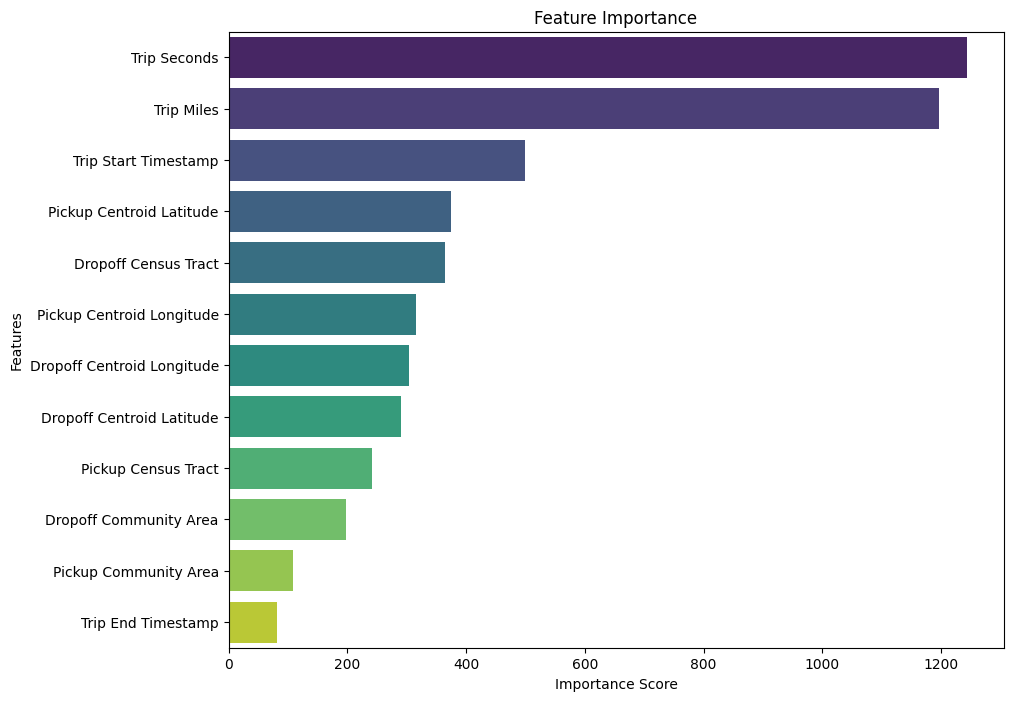

In [27]:
booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='weight')  # You can also use 'gain', 'cover', etc.

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette="viridis", dodge=False, legend=False)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

<br/>

<br/>

<br/>

# Feature Engineering
### In this section we perform a little feature engineering using pandas accelerated by our GPU due to the `%load_ext cudf.pandas` command towards the beginning.

In [28]:
%%time

# RAPIDS OFF  - 20.28
# RAPIDS A100 - 0.264 (x79 speedup)

df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data

df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name

df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])

df = df.drop(columns=["Trip ID", "Taxi ID"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")

df = df[df["trip_ttl"]>0]

CPU times: user 367 ms, sys: 153 ms, total: 520 ms
Wall time: 264 ms


### Feature Classification
##### Counting unique values is a good way to check for hidden categorical features or maybe contiuous features that are incorrectly typed.

In [29]:
%%time

# RAPIDS OFF  - 1.75
# RAPIDS A100 - 0.0215 (x70)

df.nunique().sort_values()

CPU times: user 16.4 ms, sys: 2.87 ms, total: 19.2 ms
Wall time: 21.5 ms


,0
Payment Type,9
Company,42
Pickup Community Area,77
Dropoff Community Area,77
Pickup Census Tract,292
Pickup Centroid Latitude,366
Pickup Centroid Longitude,366
Pickup Centroid Location,369
Dropoff Centroid Latitude,475
Dropoff Centroid Longitude,475


### Data Quality
##### Use `assert` for data quality checking

In [30]:
%%time

target = ["trip_ttl"]
assert len(df[target]) > 0

num_cols = ["Pickup Centroid Latitude", "Pickup Centroid Longitude", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Trip Miles", "Trip Seconds", "Trip Start Timestamp", "Trip End Timestamp"]
assert len(df[num_cols]) > 0

cat_cols = list(set(df.columns) - set(target + num_cols))
assert len(df[cat_cols]) > 0
print(cat_cols)

assert len(df.columns) == len(target) + len(num_cols) + len(cat_cols)
assert len(target + num_cols + cat_cols) == len(set(target + num_cols + cat_cols))

['Pickup Census Tract', 'Pickup Centroid Location', 'Company', 'Dropoff Community Area', 'Dropoff Centroid  Location', 'Dropoff Census Tract', 'Payment Type', 'Pickup Community Area']
CPU times: user 3.57 ms, sys: 0 ns, total: 3.57 ms
Wall time: 3.06 ms


### Impute
##### Fill in our missing values

In [31]:
%%time

# impute num cols
for col in num_cols:
  df[col] = df[col].fillna(df[col].mean())

#impute cat cols
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

CPU times: user 3.27 s, sys: 713 ms, total: 3.98 s
Wall time: 3.96 s


### Outlier Analysis
##### Analyze outliers to find bad data and remove it

In [32]:
%%time

df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles", "Payment Type"]]

CPU times: user 20.4 ms, sys: 2.23 ms, total: 22.7 ms
Wall time: 20.7 ms


,trip_ttl,Trip Seconds,Trip Miles,Payment Type
1000042,9975.32,1500.0,0.00,Cash
171827,9900.30,1158.0,0.00,Cash
1664624,9800.30,1074.0,0.00,Cash
285324,9746.85,1080.0,57.90,Credit Card
161771,9700.25,1007.0,0.00,Cash
...,...,...,...,...
1017382,0.01,40.0,0.00,Cash
1038230,0.01,38.0,0.09,Cash
1037939,0.01,38.0,0.01,Cash
1227769,0.01,36.0,0.04,Cash


In [33]:
%%time

df = df[(df['Trip Seconds'] * df['Trip Miles']) > 0]

CPU times: user 14.6 ms, sys: 2.91 ms, total: 17.5 ms
Wall time: 36.6 ms


In [34]:
def filter_by_modified_z_score(df, column, threshold=4.0):
    # median and MAD (median abs deviation)
    median = df[column].median()
    mad = (df[column] - median).abs().median()
    return df[(0.6745 * (df[column] - median) / mad).abs() <= threshold]

In [35]:
%%time

df = filter_by_modified_z_score(df, "trip_ttl", threshold=3.5)
df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles"]]

CPU times: user 44.6 ms, sys: 6.33 ms, total: 50.9 ms
Wall time: 70.2 ms


,trip_ttl,Trip Seconds,Trip Miles
426325,26.60,2880.0,3.30
653444,26.60,2460.0,5.20
1871234,26.60,2340.0,5.50
1224153,26.60,2220.0,6.10
845132,26.60,2100.0,4.50
...,...,...,...
1944300,0.01,58.0,0.32
1528258,0.01,40.0,0.10
1038230,0.01,38.0,0.09
1037939,0.01,38.0,0.01


### Feature Extraction
##### Extract date and time features

In [36]:
%%time

df['avg_speed'] = df['Trip Miles'] / (df['Trip Seconds'] / 3600)
num_cols.append('avg_speed')

df['day_of_week'] = df['Trip Start Timestamp'].dt.dayofweek
df['hour_of_day'] = df['Trip Start Timestamp'].dt.hour
df['month'] = df['Trip Start Timestamp'].dt.month
df['year'] = df['Trip Start Timestamp'].dt.year
cat_cols.extend(['day_of_week', 'hour_of_day', 'month', 'year'])


# convert to timestamp seconds since epoch
df['Trip Start Timestamp'] = df['Trip Start Timestamp'].astype(int) // 10**9
df['Trip End Timestamp'] = df['Trip End Timestamp'].astype(int) // 10**9

num_cols.extend(['Trip Start Timestamp', 'Trip End Timestamp'])

CPU times: user 17.4 ms, sys: 6.77 ms, total: 24.2 ms
Wall time: 56.7 ms


### Encode Categorical Features
##### To help our algorithm, we will do some simple encoding of our categorical features

In [37]:
%%time

# target encode cat_cols
for col in cat_cols:
  df[col] = df[col].map(df.groupby(col)["trip_ttl"].mean())

CPU times: user 231 ms, sys: 45.1 ms, total: 276 ms
Wall time: 277 ms


In [38]:
%%time


pd.set_option('display.max_columns', None)

df.sort_values("trip_ttl", ascending=False)

CPU times: user 6.51 ms, sys: 3.59 ms, total: 10.1 ms
Wall time: 8.11 ms


,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,trip_ttl,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,avg_speed,day_of_week,hour_of_day,month,year
5665,1542992400,1542994200,1620.0,5.60,9.026736,13.491123,9.673293,9.515685,26.60,11.589782,9.991409,41.899156,-87.626211,9.026736,41.878667,-87.671654,13.491123,12.444444,10.034090,10.666388,10.287562,10.135737
27000,1541611800,1541612700,1140.0,6.90,11.230968,11.209385,9.673293,13.134676,26.60,11.589782,10.028170,41.899602,-87.633308,13.312175,41.975171,-87.687516,12.937062,21.789474,9.944505,10.666388,10.287562,10.135737
58577,1542400200,1542401100,960.0,7.20,11.230968,11.209385,9.636544,18.599468,26.60,11.589782,10.063929,41.878866,-87.625192,15.722639,41.794090,-87.592311,17.837765,27.000000,10.034090,10.690281,10.287562,10.135737
75585,1541952000,1541952900,1260.0,7.20,11.230968,11.209385,11.398014,14.519452,26.60,11.589782,9.789769,41.953582,-87.723452,11.390095,41.953582,-87.723452,14.437584,20.571429,10.561506,9.987022,10.287562,10.135737
80664,1541943000,1541943000,480.0,3.60,11.230968,11.209385,16.560212,9.141873,26.60,11.589782,10.063929,41.980264,-87.913625,19.607906,41.897622,-87.650391,8.712605,27.000000,10.561506,9.421587,10.287562,10.135737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1953038,1549127700,1549128600,1581.0,21.89,14.084110,11.209385,16.560212,9.141873,0.01,8.846531,10.430743,41.979071,-87.903040,14.084110,41.897622,-87.650391,8.712605,49.844402,10.461210,10.666388,10.077806,9.969116
1953494,1548666000,1548666900,1211.0,7.33,14.084110,11.209385,16.560212,9.141873,0.01,8.846531,10.430743,41.979071,-87.903040,14.084110,41.897622,-87.650391,8.712605,21.790256,9.882814,9.812430,9.927262,9.969116
1957942,1549026900,1549028700,1818.0,13.11,11.230968,11.209385,16.560212,9.141873,0.01,8.846531,10.430743,41.980264,-87.913625,19.607906,41.897622,-87.650391,8.712605,25.960396,10.034090,9.421587,10.077806,9.969116
1963097,1549472400,1549472400,61.0,0.07,10.388689,10.567145,15.545739,12.695346,0.01,8.846531,10.430743,41.785999,-87.750934,10.388689,41.785999,-87.750934,10.567145,4.131148,9.944505,10.666388,10.077806,9.969116


In [39]:
%%time

# remove nulls/inf
df = df.replace([np.inf, -np.inf], np.nan).dropna()
df

CPU times: user 171 ms, sys: 34.4 ms, total: 205 ms
Wall time: 263 ms


,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,trip_ttl,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,avg_speed,day_of_week,hour_of_day,month,year
0,1.543099e+09,1.543099e+09,240.0,0.90,8.889187,8.399119,9.673293,8.648094,5.50,8.846531,9.918811,41.892508,-87.626215,8.889187,41.884987,-87.620993,8.399119,13.500000,10.461210,10.907608,10.287562,10.135737
1,1.543069e+09,1.543069e+09,342.0,0.91,8.840747,8.976772,9.636544,9.141873,7.00,8.846531,9.991409,41.884987,-87.620993,8.840747,41.891972,-87.612945,8.976772,9.578947,10.461210,9.590097,10.287562,10.135737
2,1.542648e+09,1.542648e+09,419.0,0.82,9.269435,11.209385,9.933901,8.648094,7.70,11.589782,10.063929,41.879255,-87.642649,9.269435,41.880994,-87.632746,8.712605,7.045346,9.882814,10.666388,10.287562,10.135737
3,1.542815e+09,1.542816e+09,479.0,1.37,8.840747,8.697326,9.636544,9.141873,9.75,11.589782,9.991409,41.884987,-87.620993,8.840747,41.895033,-87.619711,8.697326,10.296451,9.944505,9.706529,10.287562,10.135737
4,1.542604e+09,1.542605e+09,1038.0,8.74,11.230968,11.209385,11.932033,13.692171,23.75,8.846531,10.063929,41.954028,-87.763399,11.920188,41.980264,-87.913625,18.763583,30.312139,9.882814,10.416209,10.287562,10.135737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1972423,1.549474e+09,1.549475e+09,1005.0,3.20,13.677037,8.411083,11.556345,9.141873,11.75,8.846531,9.918811,41.938232,-87.646782,13.677037,41.892042,-87.631864,8.411083,11.462687,9.944505,10.666388,10.077806,9.969116
1972424,1.549489e+09,1.549490e+09,268.0,0.88,8.840747,8.978773,9.636544,9.141873,8.00,11.589782,10.140592,41.884987,-87.620993,8.840747,41.898332,-87.620763,8.978773,11.820896,9.944505,10.876360,10.077806,9.969116
1972425,1.549735e+09,1.549735e+09,450.0,1.28,9.026736,8.733624,9.673293,9.141873,10.05,11.007876,10.063929,41.899156,-87.626211,9.026736,41.890922,-87.618868,8.733624,10.240000,10.461210,10.594743,10.077806,9.969116
1972426,1.549306e+09,1.549307e+09,1288.0,4.10,11.230968,15.991460,9.636544,15.621674,14.75,8.846531,9.789769,41.880994,-87.632746,8.827250,41.920452,-87.679955,15.991460,11.459627,9.882814,10.594743,10.077806,9.969116


### XGBoost Model
##### Time to check for lift from our feature engineering

In [41]:
%%time

# RAPIDS OFF  - 103
# RAPIDS A100 - 7 (x15 speedup)

X = df.drop(columns=["trip_ttl"])
y = df["trip_ttl"]

xgb_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

for fold, (train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # train
  xgb_model = xgb.XGBRegressor(device=xgb_device)

  xgb_model.fit(X_train, y_train)
  y_pred = xgb_model.predict(X_test)
  xgb_fold_results["avg"].append(y_pred.mean())

  # metrics
  mse = ((y_test - y_pred) ** 2).mean()
  xgb_fold_results["mse"].append(mse)
  xgb_fold_results["rmse"].append(mse ** 0.5)
  mae = (y_test - y_pred).abs().mean()
  xgb_fold_results["mae"].append(mae)
  ss_residual = ((y_test - y_pred) ** 2).sum()
  ss_total = ((y_test - y_test.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  xgb_fold_results["r2"].append(1 - (ss_residual / ss_total))
  xgb_fold_results["max_err"].append((y_test - y_pred).abs().max())

xgb_fe_fold_results_df = pd.DataFrame(xgb_fold_results)

CPU times: user 5.75 s, sys: 1.87 s, total: 7.62 s
Wall time: 7.07 s


### Results
##### We have a dramatic lift in model performance from our feature engineering across all metrics

In [42]:
xgb_fe_results_df = pd.DataFrame({'model': 'xgb_fe',**xgb_fe_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_fe_fold_results_df['max_err'].max()}, index=[0])
all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df, xgb_fe_results_df]).sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True])
all_results.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,xgb_fe,10.08,1.11,1.06,0.70,0.94,25.16
0,xgb_naïve,17.61,7116.24,84.27,5.19,0.12,9850.55
0,median,9.75,8145.75,90.08,10.52,-0.01,9965.57
0,mean,17.58,8084.47,89.74,13.39,-0.00,9957.77


### Feature Importance
##### Notice 'Trip Seconds' and 'Trip Miles' are still the most important features, but below that are some new features from the Feature Importance plot above.

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='weight')  # You can also use 'gain', 'cover', etc.

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

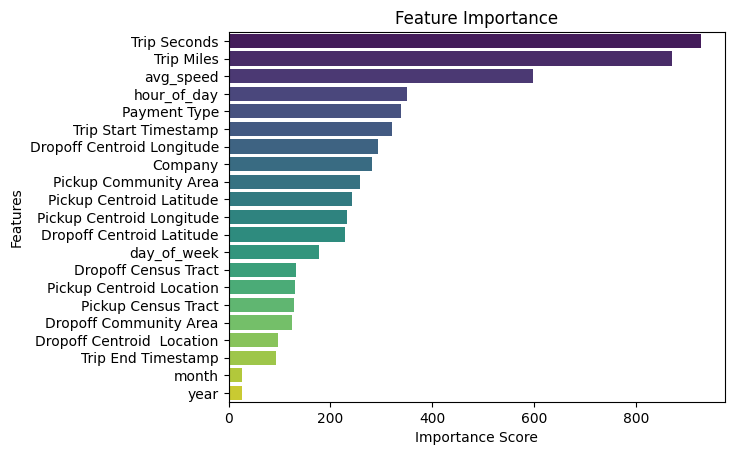

In [44]:
sns.barplot(x='Importance', y='Feature', data=importance_df.head(50), hue='Feature', palette="viridis", dodge=False, legend=False)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

<br/>

<br/>

# XGBoost Light Tuning
##### The parameter documentation can be found here:
https://xgboost.readthedocs.io/en/stable/parameter.html
##### This time we will adjust the following parameters to see if we can get some lift:
* n_estimators
* learning_rate
* max_depth
* eval_metric
* objective
* min_child

In [45]:
%%time
# RAPIDS OFF  - 270.82 (100), 543.42 (250) ; (n of estimators)
# RAPIDS A100 - 13.6(500) (x40 speedup despite twice the estimators)
# more estimators means more trees, means more likely to find optimal model

X = df.drop(columns=["trip_ttl"])
y = df["trip_ttl"]

xgb_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

for fold, (train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  # train
  xgb_model = xgb.XGBRegressor(device=xgb_device,
                               n_estimators=500,
                               learning_rate=0.05,
                               max_depth=6,
                               eval_metric="mae",
                               objective="reg:gamma",
                               min_child_weight=5
  )
  # xgb_model = xgb.XGBRegressor(device=xgb_device)

  xgb_model.fit(X_train, y_train)
  y_pred = xgb_model.predict(X_test)
  xgb_fold_results["avg"].append(y_pred.mean())

  # metrics
  mse = ((y_test - y_pred) ** 2).mean()
  xgb_fold_results["mse"].append(mse)
  xgb_fold_results["rmse"].append(mse ** 0.5)
  mae = (y_test - y_pred).abs().mean()
  xgb_fold_results["mae"].append(mae)
  ss_residual = ((y_test - y_pred) ** 2).sum()
  ss_total = ((y_test - y_test.mean()) ** 2).sum()
  r_squared = 1 - (ss_residual / ss_total)
  xgb_fold_results["r2"].append(1 - (ss_residual / ss_total))
  xgb_fold_results["max_err"].append((y_test - y_pred).abs().max())

CPU times: user 12.3 s, sys: 2.09 s, total: 14.4 s
Wall time: 13.6 s


### Results
##### The simple tuning we performed did not see to get us much lift. The default paraemeters worked just as well as this test.

In [46]:
xgb_tuned_fold_results_df = pd.DataFrame(xgb_fold_results)
xgb_tuned_results_df = pd.DataFrame({'model': 'xgb_tuned',**xgb_tuned_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_tuned_fold_results_df['max_err'].max()}, index=[0])

all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df, xgb_fe_results_df, xgb_tuned_results_df])[["model", "mae", "rmse", "mse", "r2", "max_err", "avg"]]
all_results.sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True]).round(3)

,model,mae,rmse,mse,r2,max_err,avg
0,xgb_tuned,0.692,1.051,1.105,0.945,27.155,10.081
0,xgb_fe,0.698,1.056,1.115,0.944,25.156,10.084
0,xgb_naïve,5.195,84.272,7116.241,0.115,9850.547,17.613
0,median,10.521,90.078,8145.749,-0.008,9965.570,9.750
0,mean,13.394,89.736,8084.466,-0.000,9957.770,17.579


<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

# x20 Performance Boost - All Code
### Section Simulates the Work of a Data Scientist or ML Engineer, all at once
### It is meant to showcase the struggle of buiding a model with and withOUT a NVIDIA cuDF and NVIDIA cuML
### To run the code with the GPU:
* resart your iPython kernel if needed
* set `xgb_device` to `cuda`
* run `%load_ext cudf.pandas` before importing pandas
### To run the code with the CPU:
* resart your iPython kernel if needed
* set `xgb_device` to `cpu`
* comment out the `%load_ext cudf.pandas` command

<br/>

In [ ]:
# !cp /content/drive/MyDrive/Taxi_Trips__2013-2023__20241218.csv .

In [ ]:
# xgb_device = "cpu"

%load_ext cudf.pandas
xgb_device = "cuda"

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [47]:
import pandas as pd
import numpy as np
import xgboost as xgb
from time import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [48]:
start = time()
# RAPIDS OFF  - 243.32
# RAPIDS A100 - 7.87 (x30 speedup)

#----------MEAN/MEDIAN DATA PREP--------------#
df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data
df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name
df = df[df["trip_ttl"]>0]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(0.8 * len(df))  # 80% train, 20% test
train_df = df[:split_index]
test_df = df[split_index:]
del df

X_test = test_df.drop(columns=["trip_ttl"])
y_test = test_df["trip_ttl"]

X_train = train_df.drop(columns=["trip_ttl"])
y_train = train_df["trip_ttl"]

#----------MEAN--------------#
mean_fold_results = {"avg":[], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}


y_pred = y_train.mean()
mean_fold_results["avg"].append(y_pred)

mse = ((y_test - y_pred) ** 2).mean()
mean_fold_results["mse"].append(mse)
mean_fold_results["rmse"].append(mse  ** 0.5)
mae = (y_test - y_pred).abs().mean()
mean_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
mean_fold_results["r2"].append(1 - (ss_residual / ss_total))
mean_fold_results["max_err"].append((y_test - y_pred).abs().max())


#----------MEDIAN--------------#
median_fold_results = {"avg":[], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

y_pred = y_train.median()
median_fold_results["avg"].append(y_pred)

mse = ((y_test - y_pred) ** 2).mean()
median_fold_results["mse"].append(mse)
median_fold_results["rmse"].append(mse ** 0.5)
mae = (y_test - y_pred).abs().mean()
median_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
median_fold_results["r2"].append(1 - (ss_residual / ss_total))
median_fold_results["max_err"].append((y_test - y_pred).abs().max())


#---------------------XGB NAIVE DATA PREP---------------------#
df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data
df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name
df = df[df["trip_ttl"]>0]
_ = df.sort_values(["trip_ttl"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles"]]

df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])
df = df.drop(columns=["Trip ID", "Taxi ID", "Pickup Centroid Location", "Dropoff Centroid  Location", "Payment Type", "Company"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip Start Timestamp"] = (df["Trip Start Timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df["Trip End Timestamp"] = (df["Trip End Timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(0.8 * len(df))  # 80% train, 20% test
train_df = df[:split_index]
test_df = df[split_index:]
del df

X_test = test_df.drop(columns=["trip_ttl"])
y_test = test_df["trip_ttl"]

X_train = train_df.drop(columns=["trip_ttl"])
y_train = train_df["trip_ttl"]


#----------------XGB NAIVE-------------------#
xgb_naive_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}


# train
xgb_model = xgb.XGBRegressor(device=xgb_device)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_naive_fold_results["avg"].append(y_pred.mean())

# metrics
mse = ((y_test - y_pred) ** 2).mean()
xgb_naive_fold_results["mse"].append(mse)
xgb_naive_fold_results["rmse"].append(mse ** 0.5)
mae = (y_test - y_pred).abs().mean()
xgb_naive_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
xgb_naive_fold_results["r2"].append(1 - (ss_residual / ss_total))
xgb_naive_fold_results["max_err"].append((y_test - y_pred).abs().max())


#----------------------XGB FEATURE ENGINEERING - DATA PREP-----------------------#
df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data
df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name
df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])
df = df.drop(columns=["Trip ID", "Taxi ID"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")

df = df[df["trip_ttl"]>0]
_ = df.nunique().sort_values()

target = ["trip_ttl"]
num_cols = ["Pickup Centroid Latitude", "Pickup Centroid Longitude", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Trip Miles", "Trip Seconds", "Trip Start Timestamp", "Trip End Timestamp"]
cat_cols = list(set(df.columns) - set(target + num_cols))

for col in num_cols:
  df[col] = df[col].fillna(df[col].mean())

df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles", "Payment Type"]]

df = df[(df['Trip Seconds'] * df['Trip Miles']) > 0]

def filter_by_modified_z_score(df, column, threshold=4.0):
    # median and MAD (median abs deviation)
    median = df[column].median()
    mad = (df[column] - median).abs().median()
    return df[(0.6745 * (df[column] - median) / mad).abs() <= threshold]

df = filter_by_modified_z_score(df, "trip_ttl", threshold=3.5)
_ = df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles"]]

### Feature Extraction

df['avg_speed'] = df['Trip Miles'] / (df['Trip Seconds'] / 3600)
num_cols.append('avg_speed')

df['day_of_week'] = df['Trip Start Timestamp'].dt.dayofweek
df['hour_of_day'] = df['Trip Start Timestamp'].dt.hour
df['month'] = df['Trip Start Timestamp'].dt.month
df['year'] = df['Trip Start Timestamp'].dt.year
cat_cols.extend(['day_of_week', 'hour_of_day', 'month', 'year'])

# convert to timestamp seconds since epoch
df['Trip Start Timestamp'] = df['Trip Start Timestamp'].astype(int) // 10**9
df['Trip End Timestamp'] = df['Trip End Timestamp'].astype(int) // 10**9

num_cols.extend(['Trip Start Timestamp', 'Trip End Timestamp'])

for col in cat_cols:
  df[col] = df[col].map(df.groupby(col)["trip_ttl"].mean())

_ = df.sort_values("trip_ttl", ascending=False)

df = df.replace([np.inf, -np.inf], np.nan).dropna()

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
split_index = int(0.8 * len(df))  # 80% train, 20% test
train_df = df[:split_index]
test_df = df[split_index:]
del df

X_test = test_df.drop(columns=["trip_ttl"])
y_test = test_df["trip_ttl"]

X_train = train_df.drop(columns=["trip_ttl"])
y_train = train_df["trip_ttl"]


#--------------------XGB FE----------------------------#
xgb_fe_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

# train
xgb_model = xgb.XGBRegressor(device=xgb_device)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_fe_fold_results["avg"].append(y_pred.mean())

# metrics
mse = ((y_test - y_pred) ** 2).mean()
xgb_fe_fold_results["mse"].append(mse)
xgb_fe_fold_results["rmse"].append(mse ** 0.5)
mae = (y_test - y_pred).abs().mean()
xgb_fe_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
xgb_fe_fold_results["r2"].append(1 - (ss_residual / ss_total))
xgb_fe_fold_results["max_err"].append((y_test - y_pred).abs().max())


#--------------XGB HYPERPARAMETER TUNING--------------#
xgb_tune_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

# train
xgb_model = xgb.XGBRegressor(device=xgb_device,
                              n_estimators=500,
                              learning_rate=0.05,
                              max_depth=6,
                              eval_metric="mae",
                              objective="reg:gamma",
                              min_child_weight=5
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_tune_fold_results["avg"].append(y_pred.mean())

mse = ((y_test - y_pred) ** 2).mean()
xgb_tune_fold_results["mse"].append(mse)
xgb_tune_fold_results["rmse"].append(mse ** 0.5)
mae = (y_test - y_pred).abs().mean()
xgb_tune_fold_results["mae"].append(mae)
ss_residual = ((y_test - y_pred) ** 2).sum()
ss_total = ((y_test - y_test.mean()) ** 2).sum()
r_squared = 1 - (ss_residual / ss_total)
xgb_tune_fold_results["r2"].append(1 - (ss_residual / ss_total))
xgb_tune_fold_results["max_err"].append((y_test - y_pred).abs().max())

time() - start

7.869645595550537

<br/>

<br/>

<br/>

<br/>

### results
##### This section is the visual analysis of the previous section on model building

In [49]:
mean_fold_results_df = pd.DataFrame(mean_fold_results)
mean_results_df = pd.DataFrame({'model': 'mean',**mean_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': mean_fold_results_df['max_err'].max()}, index=[0])

median_fold_results_df = pd.DataFrame(median_fold_results)
median_results_df = pd.DataFrame({'model': 'median', **median_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': median_fold_results_df['max_err'].max()}, index=[0])

xgb_naïve_fold_results_df = pd.DataFrame(xgb_naive_fold_results)
xgb_naïve_results_df = pd.DataFrame({'model': 'xgb_naïve',**xgb_naïve_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_naïve_fold_results_df['max_err'].max()}, index=[0])

xgb_fe_fold_results_df = pd.DataFrame(xgb_fe_fold_results)
xgb_fe_results_df = pd.DataFrame({'model': 'xgb_fe',**xgb_fe_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_fe_fold_results_df['max_err'].max()}, index=[0])

xgb_tuned_fold_results_df = pd.DataFrame(xgb_tune_fold_results)
xgb_tuned_results_df = pd.DataFrame({'model': 'xgb_tuned',**xgb_tuned_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_tuned_fold_results_df['max_err'].max()}, index=[0])

all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df, xgb_fe_results_df, xgb_tuned_results_df]).sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True])

all_results.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,xgb_tuned,10.07,1.09,1.04,0.69,0.95,22.55
0,xgb_fe,10.07,1.09,1.05,0.70,0.94,24.45
0,xgb_naïve,17.66,6833.55,82.67,5.24,0.11,8827.88
0,median,9.75,7702.04,87.76,10.45,-0.01,9690.50
0,mean,17.60,7641.96,87.42,13.35,-0.00,9682.65


In [50]:
mean_fold_results_df = pd.DataFrame(mean_fold_results)
mean_results_df = pd.DataFrame({'model': 'mean',**mean_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': mean_fold_results_df['max_err'].max()}, index=[0])

median_fold_results_df = pd.DataFrame(median_fold_results)
median_results_df = pd.DataFrame({'model': 'median', **median_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': median_fold_results_df['max_err'].max()}, index=[0])

xgb_naïve_fold_results_df = pd.DataFrame(xgb_naive_fold_results)
xgb_naïve_results_df = pd.DataFrame({'model': 'xgb_naïve',**xgb_naïve_fold_results_df.drop(columns=['max_err']).mean(), 'max_err': xgb_naïve_fold_results_df['max_err'].max()}, index=[0])

all_results = pd.concat([mean_results_df, median_results_df, xgb_naïve_results_df]).sort_values(by=["mae", "mse", "rmse", "r2", "max_err"], ascending=[True, True, True, False, True])

all_results.round(2)

,model,avg,mse,rmse,mae,r2,max_err
0,xgb_naïve,17.66,6833.55,82.67,5.24,0.11,8827.88
0,median,9.75,7702.04,87.76,10.45,-0.01,9690.50
0,mean,17.60,7641.96,87.42,13.35,-0.00,9682.65


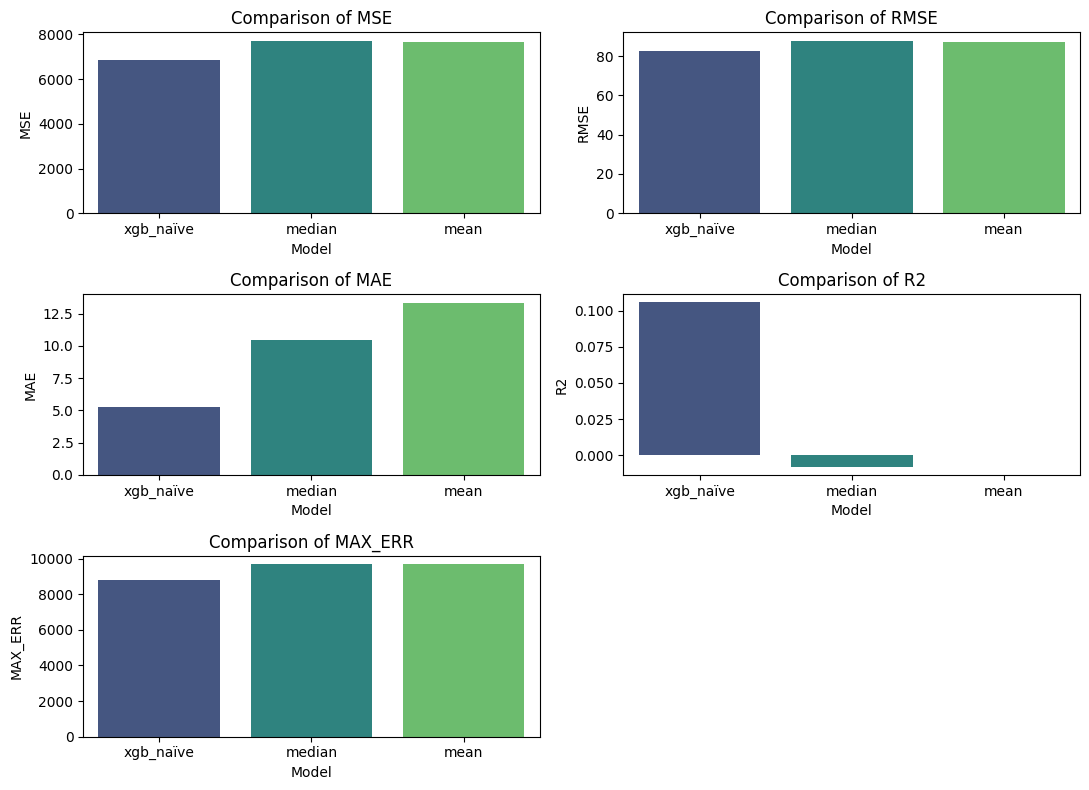

In [51]:
melted_df = all_results.melt(id_vars='model', var_name='metric', value_name='value')
filtered_df = melted_df[melted_df['metric'] != 'avg']
unique_metrics = filtered_df['metric'].unique()
n_metrics = len(unique_metrics)
n_cols = 2
n_rows = (n_metrics + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(11, 8))
axes = axes.flatten()

for i, metric in enumerate(unique_metrics):
    ax = axes[i]
    sns.barplot(
        x='model',
        y='value',
        hue='model',  # Assign 'model' to hue
        data=filtered_df[filtered_df['metric'] == metric],
        palette='viridis',
        ax=ax,
        dodge=False)

    ax.set_title(f'Comparison of {metric.upper()}')
    ax.set_ylabel(metric.upper())
    ax.set_xlabel('Model')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

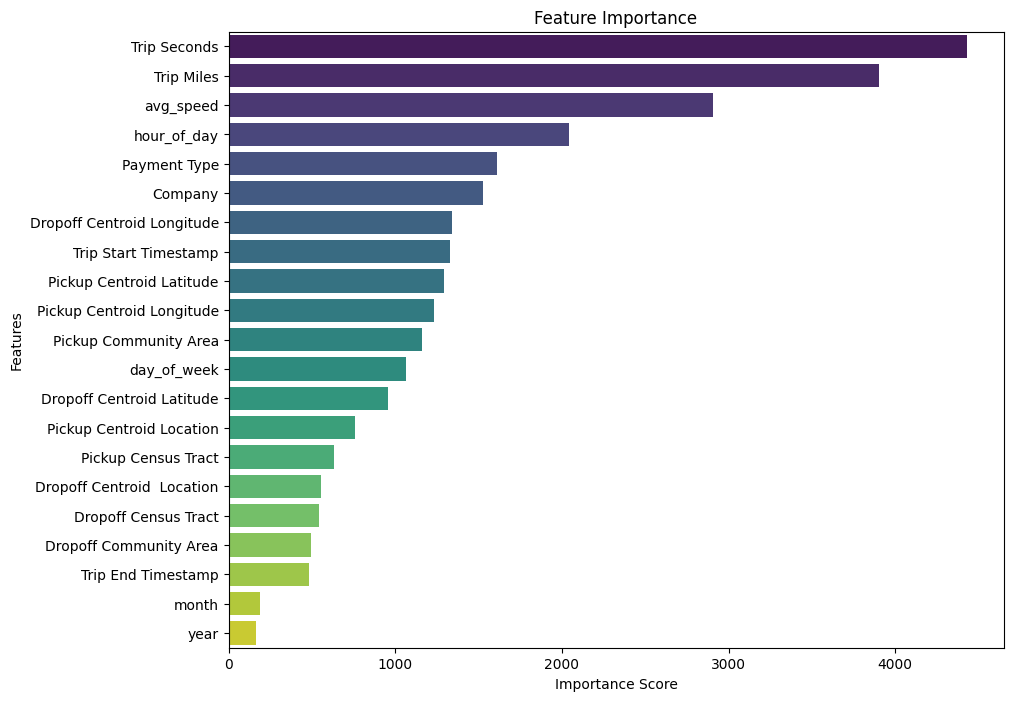

In [52]:
booster = xgb_model.get_booster()
importance = booster.get_score(importance_type='weight')  # You can also use 'gain', 'cover', etc.

# Convert to DataFrame
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot using Seaborn
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, hue='Feature', palette="viridis", dodge=False, legend=False)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

<br/>

# XGBoost Automated  Tuning
### This section is sample code on applying Hyperparameter Optimization for XGBoost using Optuna and showcases that many more trials can be run with NVIDIA cuML and NVIDIA cuDF, than without...in the same time span
### Find more details on Optuna here:
https://optuna.org/

In [53]:
%reload_ext cudf.pandas

/usr/local/lib/python3.11/dist-packages/cudf/pandas/__init__.py:65: UserWarning: cudf.pandas detected an already configured memory resource, ignoring 'CUDF_PANDAS_RMM_MODE'=managed_pool
  warnings.warn(


In [54]:
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 19.7 MB/s eta 0:00:00


In [55]:
import optuna

In [56]:
df = pd.read_csv('Taxi_Trips__2013-2023__20241218.csv')  # read in data
df = df.rename(columns={'Trip Total': 'trip_ttl'})  # abbreviate target column name
df = df.drop(columns=["Fare", "Tips", "Tolls", "Extras"])
df = df.drop(columns=["Trip ID", "Taxi ID"])

df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format="%m/%d/%Y %I:%M:%S %p")
df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format="%m/%d/%Y %I:%M:%S %p")

df = df[df["trip_ttl"]>0]
_ = df.nunique().sort_values()

target = ["trip_ttl"]
num_cols = ["Pickup Centroid Latitude", "Pickup Centroid Longitude", "Dropoff Centroid Latitude", "Dropoff Centroid Longitude", "Trip Miles", "Trip Seconds", "Trip Start Timestamp", "Trip End Timestamp"]
cat_cols = list(set(df.columns) - set(target + num_cols))

for col in num_cols:
  df[col] = df[col].fillna(df[col].mean())

df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles", "Payment Type"]]

df = df[(df['Trip Seconds'] * df['Trip Miles']) > 0]

def filter_by_modified_z_score(df, column, threshold=4.0):
    # median and MAD (median abs deviation)
    median = df[column].median()
    mad = (df[column] - median).abs().median()
    return df[(0.6745 * (df[column] - median) / mad).abs() <= threshold]

df = filter_by_modified_z_score(df, "trip_ttl", threshold=3.5)
_ = df.sort_values(["trip_ttl", "Trip Seconds", "Trip Miles"], ascending=False)[["trip_ttl", "Trip Seconds", "Trip Miles"]]

### Feature Extraction

df['avg_speed'] = df['Trip Miles'] / (df['Trip Seconds'] / 3600)
num_cols.append('avg_speed')

df['day_of_week'] = df['Trip Start Timestamp'].dt.dayofweek
df['hour_of_day'] = df['Trip Start Timestamp'].dt.hour
df['month'] = df['Trip Start Timestamp'].dt.month
df['year'] = df['Trip Start Timestamp'].dt.year
cat_cols.extend(['day_of_week', 'hour_of_day', 'month', 'year'])

# convert to timestamp seconds since epoch
df['Trip Start Timestamp'] = df['Trip Start Timestamp'].astype(int) // 10**9
df['Trip End Timestamp'] = df['Trip End Timestamp'].astype(int) // 10**9

num_cols.extend(['Trip Start Timestamp', 'Trip End Timestamp'])

for col in cat_cols:
  df[col] = df[col].map(df.groupby(col)["trip_ttl"].mean())

_ = df.sort_values("trip_ttl", ascending=False)

df = df.replace([np.inf, -np.inf], np.nan).dropna()

df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [57]:
def xgb_params_objective(trial):

  xgb_params = {
      "device": "cuda",
      "eval_metric": "mae",

      "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),

      "n_estimators": trial.suggest_int("n_estimators", 25, 500),

      "learning_rate": trial.suggest_float("learning_rate", 0.0001, 0.9),

      "objective": trial.suggest_categorical("objective", ["reg:squarederror", "reg:squaredlogerror", "reg:gamma", "reg:tweedie"])
  }

  if xgb_params['booster'] == 'gbtree':
      xgb_params["max_depth"] = trial.suggest_int("max_depth", 1, 10)
      xgb_params["min_child_weight"] = trial.suggest_int("min_child_weight", 1, 10)
      xgb_params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)
      xgb_params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.5, 1.0)

  elif xgb_params['booster'] == 'gblinear':
      xgb_params["alpha"] = trial.suggest_float("alpha", 0, 1)
      xgb_params["lambda"] = trial.suggest_float("lambda", 0, 1)
      xgb_params["feature_selector"] = trial.suggest_categorical("feature_selector", ["cyclic", "shuffle"])

  elif xgb_params['booster'] == 'dart':
      xgb_params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
      xgb_params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
      xgb_params["rate_drop"] = trial.suggest_float("rate_drop", 0.0, 1.0)
      xgb_params["skip_drop"] = trial.suggest_float("skip_drop", 0.0, 1.0)

  return xgb_params

In [58]:
def objective(trial):

  xgb_params = xgb_params_objective(trial)

  xgb_auto_tune_fold_results = {"avg": [], "mse": [], "rmse": [], "mae": [], "r2": [], "max_err": []}

  X = df.drop(columns=["trip_ttl"])
  y = df["trip_ttl"]

  for fold, (train_index, test_index) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(df)):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # train
    xgb_model = xgb.XGBRegressor(**xgb_params)

    start = time()
    xgb_model.fit(X_train, y_train)
    fit_time = time() - start
    trial.set_user_attr("fit_time", fit_time)

    y_pred = xgb_model.predict(X_test)
    xgb_auto_tune_fold_results["avg"].append(y_pred.mean())

    # metrics
    mse = ((y_test - y_pred) ** 2).mean()
    xgb_auto_tune_fold_results["mse"].append(mse)

    xgb_auto_tune_fold_results["rmse"].append(mse ** 0.5)

    xgb_auto_tune_fold_results["mae"].append((y_test - y_pred).abs().mean())

    ss_residual = ((y_test - y_pred) ** 2).sum()
    ss_total = ((y_test - y_test.mean()) ** 2).sum()
    xgb_auto_tune_fold_results["r2"].append(1 - (ss_residual / ss_total))

    xgb_auto_tune_fold_results["max_err"].append((y_test - y_pred).abs().max())

  xgb_auto_tune_fold_results_df = pd.DataFrame(xgb_auto_tune_fold_results)
  xgb_auto_tune_results_df = pd.DataFrame({'model': 'xgb_auto_tune',
                                           **xgb_auto_tune_fold_results_df.drop(columns=['max_err']).mean(),
                                           'max_err': xgb_auto_tune_fold_results_df['max_err'].max()}, index=[0])


  return xgb_auto_tune_fold_results_df["mae"].mean()

In [59]:
study = optuna.create_study(direction="minimize")

[I 2025-06-26 13:38:54,920] A new study created in memory with name: no-name-25f4d5ae-b1a3-45e7-919f-ca9a77e4e75a


In [ ]:
!date
study.optimize(objective, timeout=10)
!date

Thu Jun 26 01:38:58 PM UTC 2025


In [ ]:
!date
study.optimize(objective, timeout=10)
!date

In [ ]:
!date
for i in range(6):
    study.optimize(objective, timeout=10, n_jobs=16)
!date